In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 203ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4699
Epoch 2/50
53/53 [==============================] - 10s 190ms/step - loss: 0.1934 - root_mean_squared_error: 0.4398 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3195
Epoch 3/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0493 - root_mean_squared_error: 0.2219 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1875
Epoch 4/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1794
Epoch 5/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0318 - root_mean_squared_error: 0.1784 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1551
Epoch 6/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0215 

53/53 [==============================] - 10s 198ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0738
Epoch 33/50
53/53 [==============================] - 1s 26ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 34/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 35/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0093 - root_mean_squared_error: 0.0967 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 36/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 37/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0067 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.827826337019602 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

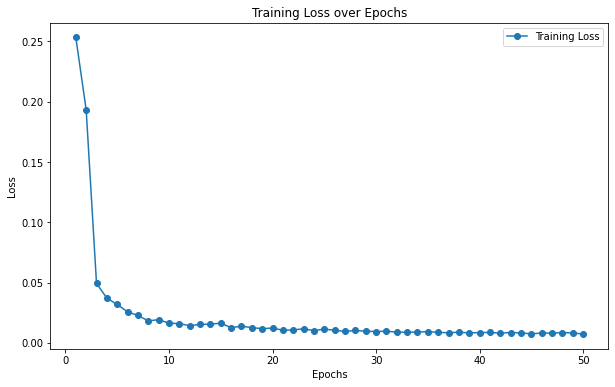

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

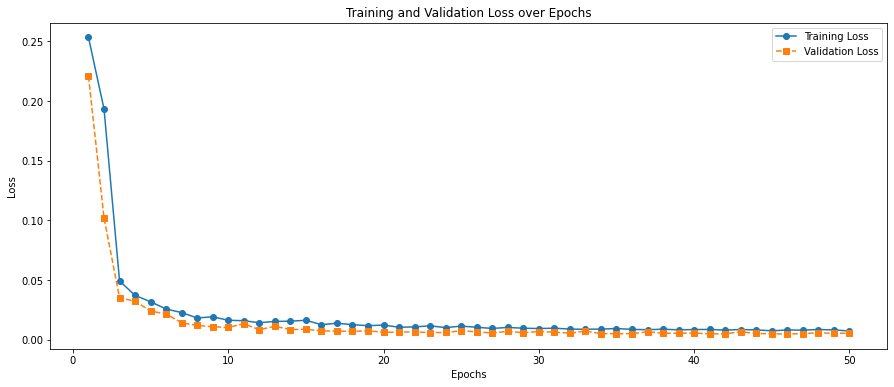

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06737436391779979
MAE : 0.055019674760867006


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.338510e+06,1400934.040
1,1.534929e+06,1701391.499
2,1.666167e+06,1890231.668
3,1.734506e+06,2203401.829
4,1.632564e+06,1960480.542
5,1.260341e+06,1264318.504
6,7.016260e+05,863206.294
7,4.083290e+05,635624.004
8,3.769529e+05,460009.672
9,4.861302e+05,610848.036


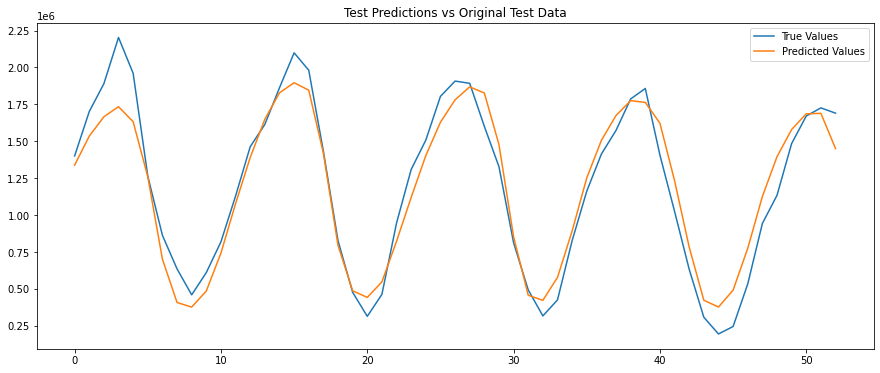

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

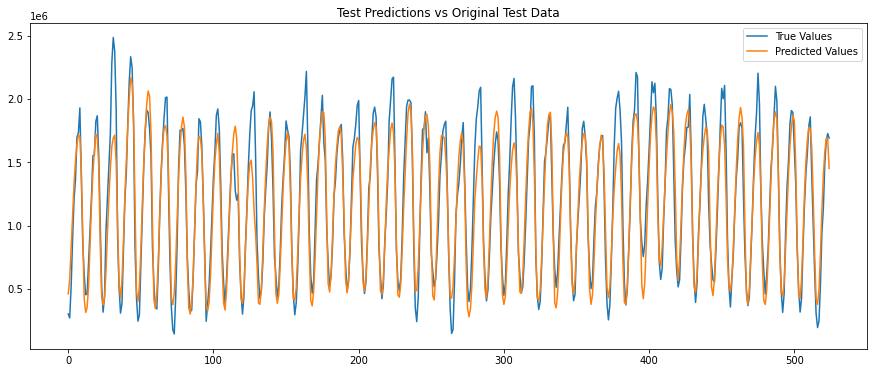

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()